# Evaluating KNN, Linear Regression, SVR, XGBoost Regressor, Random Forest, ANN Models for Dengue Case Prediction: A Comparative Study

## Kurt Matthew Amodia, Glen Andrew Bulaong, Carl Benedict Elipan, John Hamir Karim


# Table of Contents

1. [Introduction](#introduction)
2. [Importing Libraries](#importing-libraries)
3. [Load Dengue Dash Dataset and Preprocess Data](#load-dengue-dash-dataset-and-preprocess-data)
4. [Normalize Dataset](#normalize-dataset)
5. [Split the Dataset](#split-the-dataset)
6. [Moving Average Function](#moving-average-function)
7. [Feature Columns Definition](#feature-columns-definition)
8. [Linear Regression Model Training](#linear-regression-model-training)
9. [Random Forest Model Training](#random-forest-model-training)
10. [Artificial Neural Network (ANN) Model Training](#artificial-neural-network-ann-model-training)
11. [XGBoost Model Training](#xgboost-model-training)
12. [SVR Model Training](#svr-model-training)
13. [KNN Model Training](#knn-model-training)
14. [Model Evaluation and Display](#model-evaluation-and-display)
15. [Validation of Model MSE, RMSE, MAE](#validation-of-model-mse-rmse-mae)
16. [Plot the Results](#plot-the-results)
17. [Plot All Models' Predictions](#plot-all-models-predictions)
18. [Main Workflow](#main-workflow)

### Introduction
This study analyzes dengue data  in Iloilo City from the Humanitarian Data Exchange, Western Visayas Center for Health Development (WVCHD) via Freedom of Information  and weather data from wunderground, using six machine learning algorithms: K-Nearest Neighbors (KNN), Linear Regression, Support Vector Regression (SVR), Random Forest, Artificial Neural Network (ANN), and XGBoost Regression

### Importing Libraries

In [ ]:
# Data manipulation, Visualization and analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # For feature scaling (normalization)

# Machine Learning Algorithms
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Import necessary libraries for Artificial Neural Networks (ANN)
from tensorflow.keras.models import Sequential  # For building sequential neural network models
from tensorflow.keras.layers import Dense, Input  # For defining layers in the neural network
from tensorflow.keras.optimizers import Adam  # For optimization in ANN training
from tensorflow.keras.callbacks import EarlyStopping  # For stopping training early based on validation performance


# Model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


### Load Dengue Dash Dataset and Preprocess Data
* Target
    * Cases (weekly dengue cases)
* Features
    * Rainfall in mm
    * Temperature in °C
    * Humidity in %

In [ ]:
def load_and_preprocess_data(file_path: str):
    """
    Load and preprocess the dataset.
    """
    df = pd.read_csv(file_path)
    df = df.drop('Time', axis=1)
    df.columns = ["Rainfall", "Temperature", "Humidity", "Cases"]
    return df

### Normalizes dataset by scaling each feature to a range of 0 to 1

 $$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

In [ ]:
def normalize_data(X: pd.DataFrame, y: pd.Series):
    """
    Normalize features and target using MinMaxScaler.
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    X_normalized = scaler_features.fit_transform(X)
    y_normalized = scaler_target.fit_transform(y.values.reshape(-1, 1))
    return X_normalized, y_normalized, scaler_features, scaler_target

### Split the dataset
* Training Data
   * Janurary 2016 to Januray 9, 2023
* Testing Data
   * Janurary 16, 2023 to October 28, 2024  

In [ ]:
def split_data(X: pd.DataFrame, y: pd.Series, train_ratio: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

### Moving Average Function

This function calculates moving averages for specific columns with multiple window sizes while avoiding data leakage.

**Parameters:**
- `df`: pandas DataFrame containing the data.
- `columns`: List of column names to apply the moving average.
- `window_sizes`: List of integers representing the window sizes (default: `[3, 7, 14]`).

**Process:**
- For each column in `columns`:
  - Shift the data by 1 to exclude the current value.
  - Compute the moving average for each window size.
  - Add a new column with the format `<column>_<window>_MA` to the DataFrame.

**Returns:**
- A new DataFrame containing the original data and the moving average columns.


In [ ]:
def apply_moving_average(df: pd.DataFrame, columns: list, window_sizes: list = [3, 7, 14]):
    """
    Apply moving average to specified columns with multiple window sizes,
    using only past data to prevent data leakage.
    """
    df_ma = df.copy()
    for column in columns:
        for window in window_sizes:
            col_name = f'{column}_{window}_MA'
            df_ma[col_name] = df_ma[column].shift(1).rolling(window=window, closed='left').mean()
    return df_ma

### Feature Columns Definition

This function returns a list of feature column names to be used in the model, including the original features and their weekly moving averages.

**Features:**
- **Original Features:**
  - `Rainfall`
  - `Temperature`
  - `Humidity`
- **Weekly Moving Averages:**
  - `Rainfall`: 3-week, 7-week, 14-week moving averages (`Rainfall_3_MA`, `Rainfall_7_MA`, `Rainfall_14_MA`)
  - `Temperature`: 3-week, 7-week, 14-week moving averages (`Temperature_3_MA`, `Temperature_7_MA`, `Temperature_14_MA`)
  - `Humidity`: 3-week, 7-week, 14-week moving averages (`Humidity_3_MA`, `Humidity_7_MA`, `Humidity_14_MA`)
  - `Cases`: 3-week, 7-week, 14-week moving averages (`Cases_3_MA`, `Cases_7_MA`, `Cases_14_MA`)

**Purpose:**
This list dynamically selects both the original features and their derived weekly moving averages for model training.

In [ ]:
def define_feature_columns() -> list[str]:
    """
    Define the list of feature columns including moving averages.
    """
    return [
        'Rainfall', 'Temperature', 'Humidity',  # Original features
        'Rainfall_3_MA', 'Rainfall_7_MA', 'Rainfall_14_MA',  # Rainfall moving averages
        'Temperature_3_MA', 'Temperature_7_MA', 'Temperature_14_MA',  # Temperature moving averages
        'Humidity_3_MA', 'Humidity_7_MA', 'Humidity_14_MA',  # Humidity moving averages
        'Cases_3_MA', 'Cases_7_MA', 'Cases_14_MA'  # Cases moving averages
    ]

### Linear Regression Model Training

**Process:**
- A `LinearRegression` model is initialized.
- The model is trained using the provided `X_train` and `y_train` data with the `.fit()` method.

**Returns:**
- The trained `LinearRegression` model.

In [ ]:
def train_linear_model(X_train: pd.DataFrame, y_train: pd.Series):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

### Random Forest Model Training

**Process:**
   - A `RandomForestRegressor` model is initialized with 100 trees (`n_estimators=100`) and a fixed random seed (`random_state=42`).


In [ ]:
def train_random_forest_model(X_train: pd.DataFrame, y_train: pd.Series):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train.ravel())
    return rf_model

### Artificial neural network (ANN) Model Training

**Process:**
1. **ANN Structure:**
   - The model consists of:
     - An input layer with the shape matching the number of features.
     - A hidden layer with 64 neurons and ReLU activation.
     - An output layer with 1 neuron (for regression).
2. **Model Compilation:**
   - The model is compiled with the Adam optimizer (learning rate: 0.001) and Mean Squared Error (MSE) loss function.
3. **Early Stopping:**
   - Early stopping is used to prevent overfitting, monitoring validation loss with a patience of 10 epochs.
4. **Training:**
   - The model is trained for up to 200 epochs with a batch size of 16.
   - Validation data (`X_test`, `y_test`) is provided during training to evaluate performance.

**Returns:**
- The trained ANN model.
- The training history object, which includes details of the training process (loss, validation loss, etc.).

In [ ]:
def train_ann_model(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    """
    Train an Artificial Neural Network (ANN) model.
    """
    # Define the ANN structure
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1],)))
    ann_model.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
    ann_model.add(Dense(1))  # Output layer

    # Compile the model
    ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = ann_model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=16,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stopping]
    )

    return ann_model, history

### XGBoost Model Training

**Process:**
   - An `XGBRegressor` model is initialized with the following parameters:
     - `n_estimators=200`: The model will use 200 boosting rounds (increased from 100).
     - `learning_rate=0.05`: A reduced learning rate for slower convergence.
     - `max_depth=6`: Slightly increased depth for better model complexity.
     - `min_child_weight=1`: The minimum sum of instance weight needed in a child.
     - `subsample=0.8`: 80% of the training data is used for each boosting round.
     - `colsample_bytree=0.8`: 80% of features are used for each boosting round.
     - `random_state=42`: A fixed random seed.


In [ ]:
def train_xgboost_model(X_train: pd.DataFrame, y_train: pd.Series):
    """
    Train an XGBoost model.
    """
    model = xgb.XGBRegressor(
        n_estimators=200,  # Increased from 100
        learning_rate=0.05,  # Reduced learning rate
        max_depth=6,  # Slightly increased depth
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

### SVR Model Training

**Process:**
1. **Flatten Target:**
   - The target variable (`y_train`) is flattened to a 1-dimensional array using `.ravel()` to avoid shape errors.
2. **SVR Model:**
   - An `SVR` model is initialized with the following parameters:
     - `kernel='rbf'`: Radial basis function kernel for the SVR.
     - `C=100`: Regularization parameter (controls the trade-off between achieving a low error on the training data and minimizing the model complexity).
     - `gamma=0.01`: Kernel coefficient for the RBF kernel.
     - `epsilon=0.02`: Defines the margin of tolerance for errors.

In [ ]:
def train_svr_model(X_train: pd.DataFrame, y_train: pd.Series):
    """
    Train an SVR (Support Vector Regression) model.
    """
    # Flatten y_train to 1 dimension
    y_train = y_train.ravel()

    svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.02)
    svr_model.fit(X_train, y_train)
    return svr_model

### KNN Model Training
**Process:**
- `n_neighbors`: The number of neighbors to use for prediction (default: 3).
- `algorithm`: The algorithm to use for computing nearest neighbors (`'auto'`, `'ball_tree'`, `'kd_tree'`, or `'brute'`).
- `metric`: The distance metric to use for nearest neighbors (`'manhattan'` by default).
- `weights`: The weight function used in prediction (`'distance'` by default, meaning closer neighbors have more influence).




In [ ]:
def train_knn_model(X_train: pd.DataFrame, y_train: pd.Series, n_neighbors: int = 3, algorithm: str = 'auto', metric: str = 'manhattan', weights: str = 'distance'):

    knn_model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        algorithm=algorithm,
        metric=metric,
        weights=weights
    )

    # Train the model
    knn_model.fit(X_train, y_train)

    return knn_model

### Model Evaluation and Display

This function evaluates a model's performance, displays metrics, and visualizes the results.

- Predicts the target variable using the model.
- Converts predictions back to the original scale.
- Sets negative predictions to zero.
- Computes performance metrics: MSE, RMSE, and MAE.
- Visualizes results.

In [ ]:
from typing import Union
def evaluate_and_display_model(
        model: Union[SVR, KNeighborsRegressor, LinearRegression, RandomForestRegressor, Sequential, xgb.XGBRegressor], 
        X_test: pd.DataFrame, 
        y_test: pd.Series, 
        scaler_target: MinMaxScaler
    ):
    """
    Evaluate a given model and display its performance metrics.
    """
    # Predict
    y_test_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_test_actual = scaler_target.inverse_transform(y_test)
    y_test_pred_original = scaler_target.inverse_transform(y_test_pred.reshape(-1, 1))

    # Set negative predictions to zero
    y_test_pred_original = np.maximum(y_test_pred_original, 0)

    # Create results DataFrame
    test_results = pd.DataFrame({
        'Actual': y_test_actual.flatten(),
        'Predicted': y_test_pred_original.flatten()
    }).reset_index(drop=True)

    # Performance metrics
    mse = mean_squared_error(test_results['Actual'], test_results['Predicted'])
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_results['Actual'] - test_results['Predicted']))

    print_performance_metrics(mse, rmse, mae)

    # Visualization
    plot_results(test_results)

    return test_results

### Validation of model mse, rmse, mae

In [ ]:
def print_performance_metrics(mse, rmse, mae) -> None:
    """
    Print model evaluation metrics.
    """
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

### Plot the results
* Visualize each model plot where actual dengue weekly cases is in blue
* Each model prediction of weekly dengue cases is in red

In [ ]:
def plot_results(test_results):
    """
    Plot actual vs predicted values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_results.index, test_results['Actual'], label='Actual', color='blue')
    plt.plot(test_results.index, test_results['Predicted'], label='Predicted', color='red')
    plt.title('Actual vs. Predicted Dengue Cases')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot all the models prediction of dengue weekly cases in one figure
* Actual Dengue weekly cases is in blue
* KNN Dengue weekly cases is in red
* SVR Dengue weekly cases is in green
* ANN Dengue weekly cases is in purple
* XGBoost Dengue weekly cases is in orange
* Linear Regressionn Dengue weekly cases is in brown
* Random Forest Dengue weekly cases is in yellow

In [34]:
def plot_model_comparisons(test_results_dict: dict):
    """
    Plot a comparison of different model predictions against actual values.
    """
    plt.figure(figsize=(15, 8))

    # Plot actual values in blue
    plt.plot(test_results_dict['Actual'].index,
             test_results_dict['Actual'],
             label='Actual',
             color='blue',
             linewidth=3)

    # Define color scheme for models
    model_colors = {
        'KNN': 'red',
        'SVR': 'green',
        'ANN': 'purple',
        'XGBoost': 'orange',
        'Linear Regression': 'brown',
        'Random Forest': 'yellow'
    }

    # Plot predictions for each model
    for model_name, predictions in test_results_dict.items():
        if model_name != 'Actual':
            plt.plot(predictions.index,
                     predictions,
                     label=model_name,
                     color=model_colors.get(model_name, 'gray'),
                     linestyle='--')

    plt.title('Model Predictions Comparison')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Main Workflow

Runs the entire Dengue case prediction pipeline, including:
1. Loading and preprocessing data.
2. Applying moving averages.
3. Defining features and target variables.
4. Normalizing data.
5. Splitting data into training and testing sets.
6. Training and evaluating multiple models: KNN, SVR, ANN, XGBoost, Linear Regression, and Random Forest.
7. Comparing model predictions.

**Returns:**
- Model performance comparisons and plots.


Training KNN Model...

Evaluating KNN Model...
Mean Squared Error (MSE): 2344.9568399581726
Root Mean Squared Error (RMSE): 48.42475441298771
Mean Absolute Error (MAE): 25.785545568324824


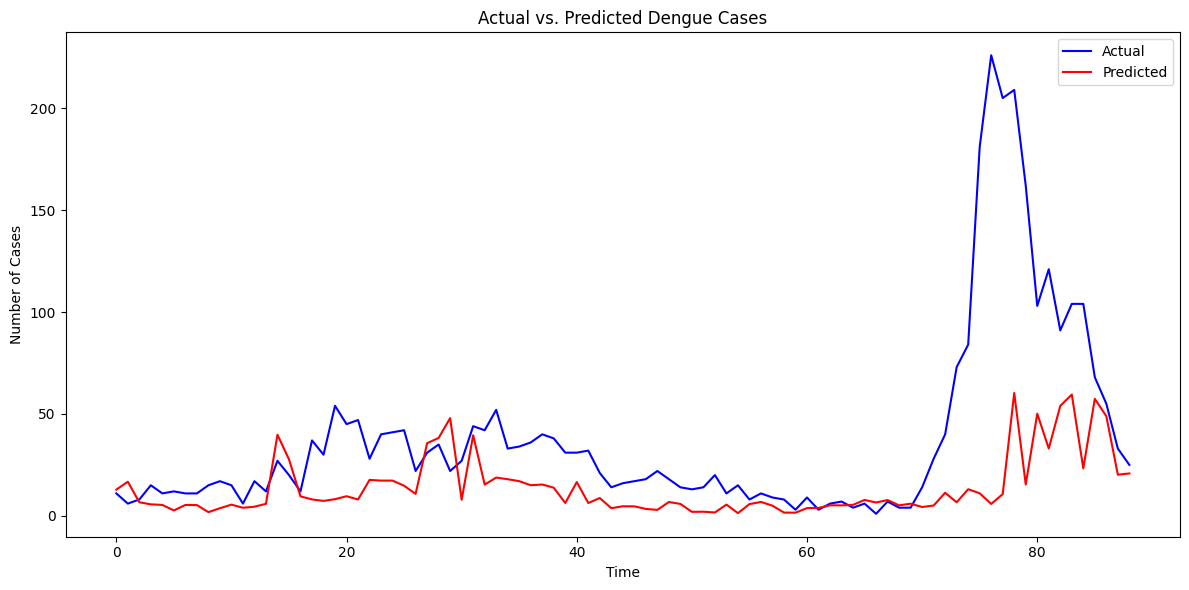


Training SVR Model...

Evaluating SVR Model...
Mean Squared Error (MSE): 898.0991625575706
Root Mean Squared Error (RMSE): 29.968302630572367
Mean Absolute Error (MAE): 15.34580087509108


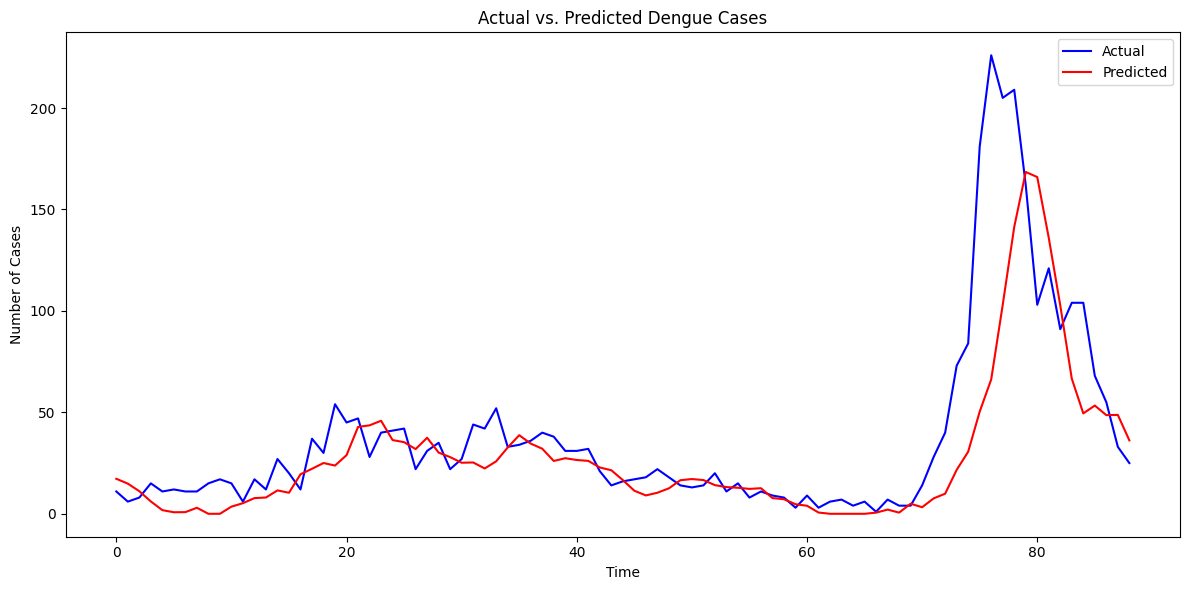


Training ANN Model...
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1005 - val_loss: 0.0302
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0211
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.0161
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0145
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0158
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0157
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0116
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0106
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0109
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0103
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━

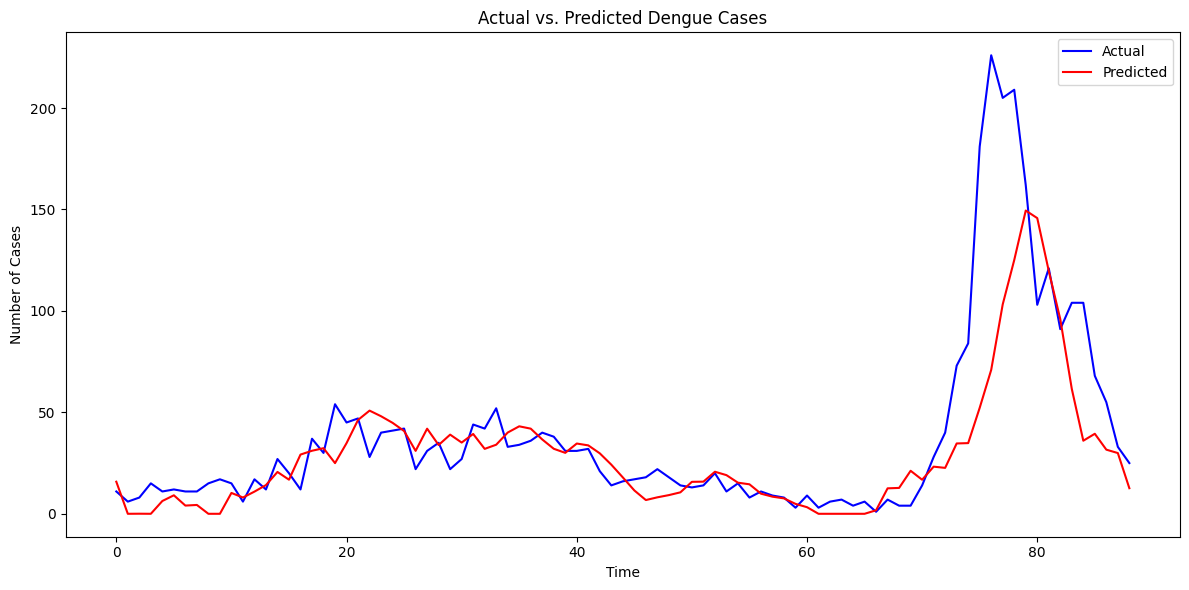


Training XGBoost Model...

Evaluating XGBoost Model...
Mean Squared Error (MSE): 759.4290630833843
Root Mean Squared Error (RMSE): 27.557740529357343
Mean Absolute Error (MAE): 18.874938013848293


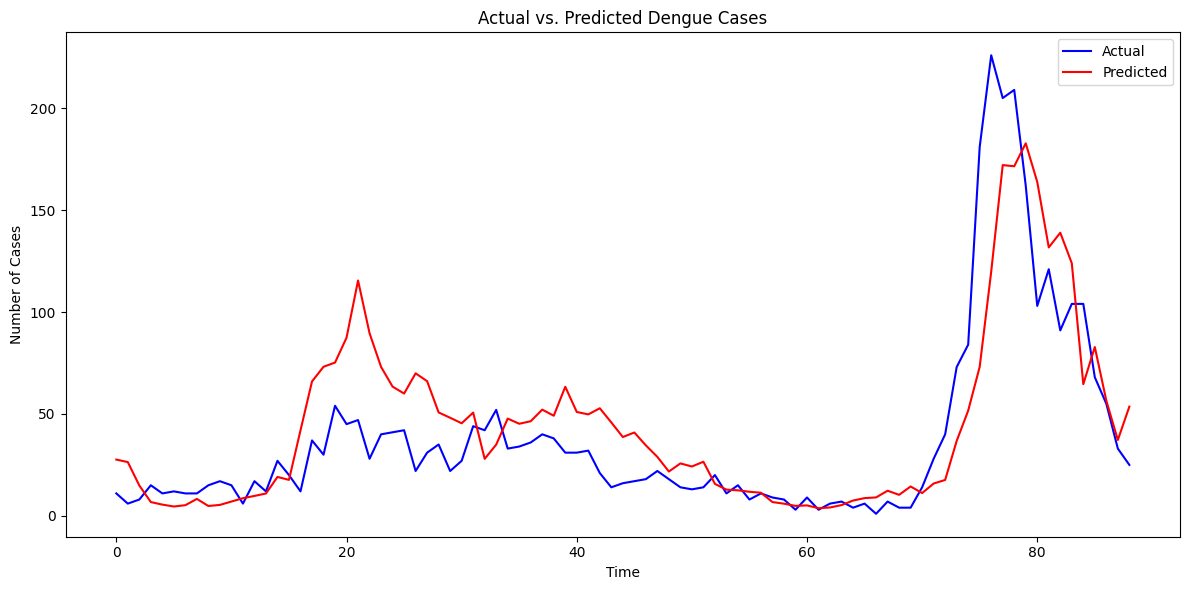


Training Linear Regression Model...

Evaluating Linear Regression Model...
Mean Squared Error (MSE): 874.2463575449317
Root Mean Squared Error (RMSE): 29.567657288749334
Mean Absolute Error (MAE): 16.372472779870073


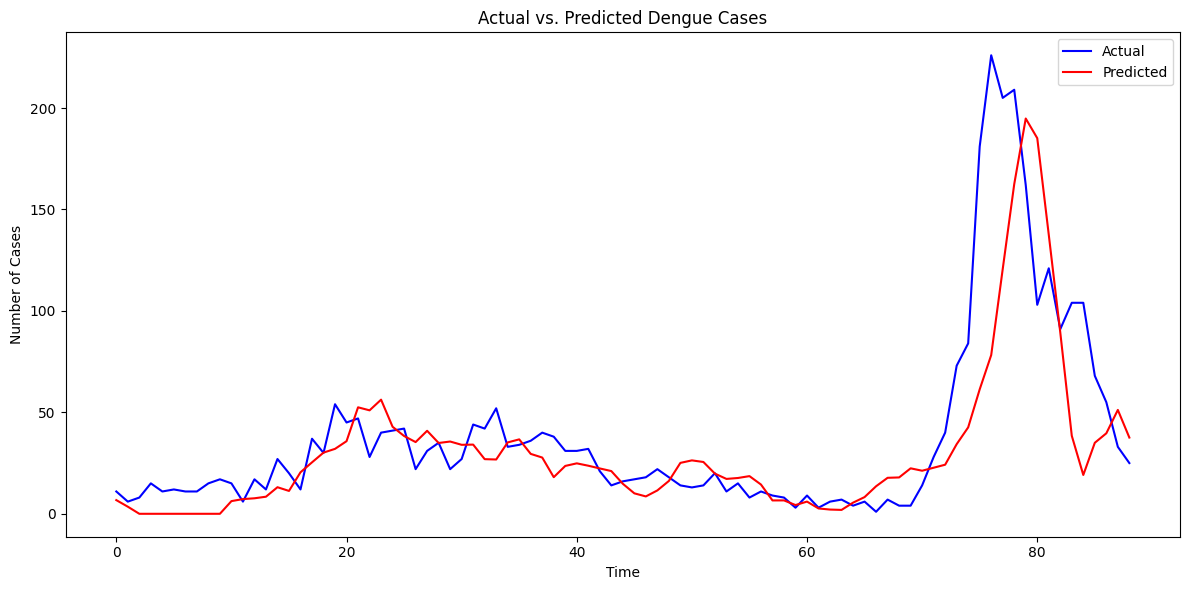


Training Random Forest Model...

Evaluating Random Forest Model...
Mean Squared Error (MSE): 645.5732786516852
Root Mean Squared Error (RMSE): 25.408134104095193
Mean Absolute Error (MAE): 16.726741573033706


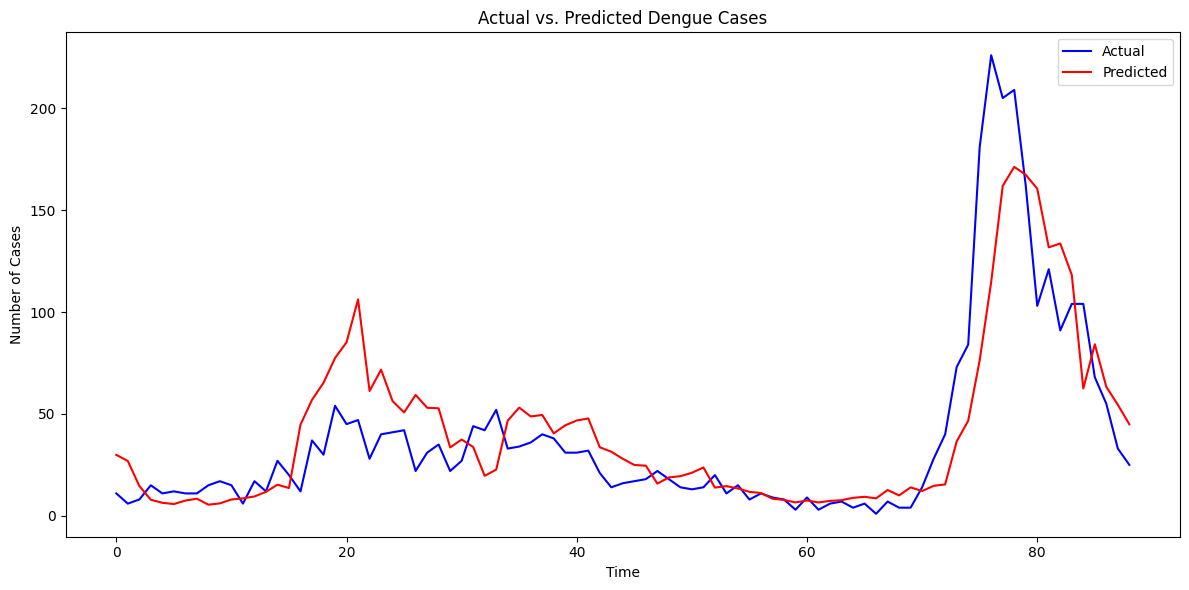


 MODEL COMPARISONS 


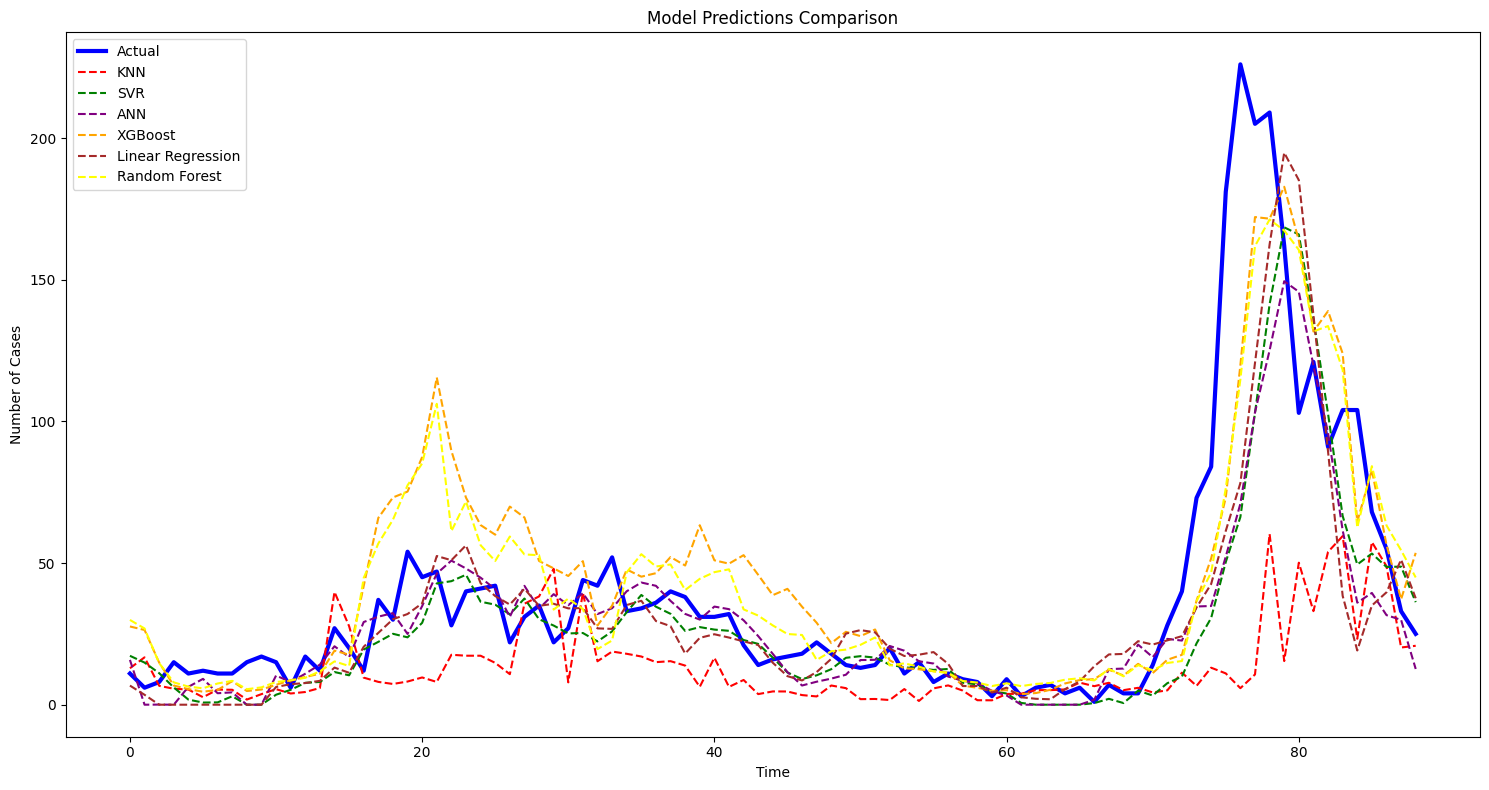

In [35]:
def main():
    """
    Main workflow for the Dengue case prediction project with various models.
    """
    # Step 1: Load and preprocess data
    file_path = '/content/drive/MyDrive/datasets/denguedash_dataset.csv'
    df = load_and_preprocess_data(file_path)

    # Step 2: Apply moving averages
    columns_to_smooth = ['Rainfall', 'Temperature', 'Humidity', 'Cases']
    window_sizes = [3, 7, 14]
    df_ma = apply_moving_average(df, columns_to_smooth, window_sizes)
    df_ma = df_ma.dropna()  # Drop rows with NaN values

    # Step 3: Define features and target
    feature_columns = define_feature_columns()
    X = df_ma[feature_columns]
    y = df_ma['Cases']

    # Step 4: Normalize features and target
    X_normalized, y_normalized, scaler_features, scaler_target = normalize_data(X, y)

    # Step 5: Split data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(X_normalized, y_normalized)

    # Dictionary to store results for each model
    model_results = {}

    # Train and evaluate the KNN model
    print("\nTraining KNN Model...")
    knn_model = train_knn_model(X_train, y_train)
    print("\nEvaluating KNN Model...")
    knn_results = evaluate_and_display_model(knn_model, X_test, y_test, scaler_target)
    model_results['KNN'] = knn_results['Predicted']

    # Train and evaluate the SVR model
    print("\nTraining SVR Model...")
    svr_model = train_svr_model(X_train, y_train)
    print("\nEvaluating SVR Model...")
    svr_results = evaluate_and_display_model(svr_model, X_test, y_test, scaler_target)
    model_results['SVR'] = svr_results['Predicted']

    # Train and evaluate the ANN model
    print("\nTraining ANN Model...")
    ann_model, ann_history = train_ann_model(X_train, y_train, X_test, y_test)
    print("\nEvaluating ANN Model...")
    ann_results = evaluate_and_display_model(ann_model, X_test, y_test, scaler_target)
    model_results['ANN'] = ann_results['Predicted']

    # Train and evaluate the XGBoost model
    print("\nTraining XGBoost Model...")
    xgboost_model = train_xgboost_model(X_train, y_train)
    print("\nEvaluating XGBoost Model...")
    xgboost_results = evaluate_and_display_model(xgboost_model, X_test, y_test, scaler_target)
    model_results['XGBoost'] = xgboost_results['Predicted']

    # Train and evaluate the Linear Regression model
    print("\nTraining Linear Regression Model...")
    linear_model = train_linear_model(X_train, y_train)
    print("\nEvaluating Linear Regression Model...")
    linear_results = evaluate_and_display_model(linear_model, X_test, y_test, scaler_target)
    model_results['Linear Regression'] = linear_results['Predicted']

    # Train and evaluate the Random Forest model
    print("\nTraining Random Forest Model...")
    rf_model = train_random_forest_model(X_train, y_train)
    print("\nEvaluating Random Forest Model...")
    rf_results = evaluate_and_display_model(rf_model, X_test, y_test, scaler_target)
    model_results['Random Forest'] = rf_results['Predicted']

    # Add the actual values to the model_results for plotting
    model_results['Actual'] = knn_results['Actual']

    print("\n MODEL COMPARISONS ")

    # Plot the comparative model predictions
    plot_model_comparisons(model_results)

if __name__ == "__main__":
    main()